<a href="https://colab.research.google.com/github/felipecostapereira/HIML/blob/main/task_07_NeuralNetworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Task 07: ANN

Using the 3-storey dataset from previous activities, perform the following 
(having features constructed with AR models and PCA):
- Build an artificial neural network for multiclass classification
  - Suggestion: use the tensorflow tutorial and adjust hyperparameters manually
- Test it using the same protocol used for other models (hold-out for testing)
- Try to compare the results with other models

In [188]:
# execute this for the 1st time
# !pip install -r example-requirements.txt 

# download file 
# !wget http://helon.usuarios.rdc.puc-rio.br/data/data3SS2009.mat # linux

# and place in folder data/

In [189]:
# !pip install statsmodels --upgrade

In [190]:
import scipy.io as sio
import numpy as np
from os import getcwd
from os.path import join 
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

from tqdm import tqdm

#allow to print all variables in the notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

from scipy import stats

# tarefa 07 redes neurais
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

### Opening data file and Separating parameters and labels

In [191]:
fname = join(getcwd(),'/content/drive/MyDrive/Colab Notebooks/Mestrado/MEC2014/data','data3SS2009.mat')
mat_contents = sio.loadmat(fname)

dataset = mat_contents['dataset']
N, Chno, Nc = dataset.shape
y = mat_contents['labels'].reshape(Nc)

### Creating new label y2 considering the classification as: (in case we use it as a supervised label instead of the 17 classes)

- y=(1..9) - undamaged, y2 = 0
- y=(10..17) - damaged, y2 = 1

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


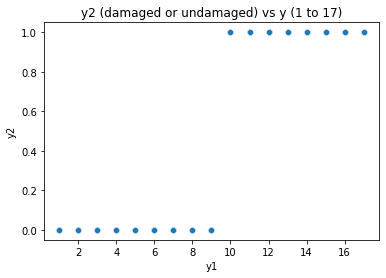

In [192]:
y2 = []
for label in y:
    if label in range(1,10):
        y2.append(0)
    else: y2.append(1)
y2 = np.array(y2)
ax = sns.scatterplot(y,y2)
ax.set_title('y2 (damaged or undamaged) vs y (1 to 17)')
ax.set_xlabel('y1')
ax.set_ylabel('y2')
pass;

In [193]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Building AR Model

In [194]:
modelOrder = 30

x2 = dataset[:,1,:].transpose() # acelerômetro: base
x3 = dataset[:,2,:].transpose() # acelerômetro: 1o andar
x4 = dataset[:,3,:].transpose() # acelerômetro: 2o andar
x5 = dataset[:,4,:].transpose() # acelerômetro: 3o andar

x2r = [] 
x3r = []
x4r = []
x5r = []

for case in x2: #iterating over cases (observations #=850)
    res = AutoReg(case, lags = modelOrder-1).fit()
    x2r.append(res.params)
for case in x3: #iterating over cases (observations #=850)
    res = AutoReg(case, lags = modelOrder-1).fit()
    x3r.append(res.params)
for case in x4: #iterating over cases (observations #=850)
    res = AutoReg(case, lags = modelOrder-1).fit()
    x4r.append(res.params)
for case in x5: #iterating over cases (observations #=850)
    res = AutoReg(case, lags = modelOrder-1).fit()
    x5r.append(res.params)

X1 = np.concatenate([x2r, x3r, x4r, x5r], axis=1)
X1.shape

(850, 120)

### PCA analysis

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


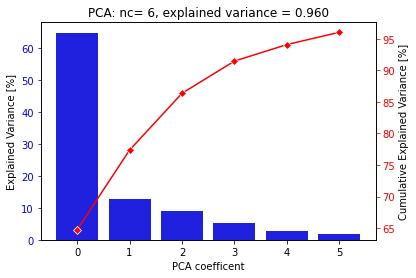

In [195]:
nComponents = 0.95  # variance ratio to be explained or number of components if integer

pca = PCA(n_components=nComponents).fit(X1)
pcaVariances = pca.explained_variance_ratio_
pcaComponents = [i for i in range(len(pcaVariances))]

ax = sns.barplot(pcaComponents, pcaVariances*100, color='b');
ax2 = ax.twinx()
ax2 = sns.lineplot(pcaComponents, np.cumsum(pcaVariances)*100, color='r', marker='D');
ax.tick_params(axis='y', colors='b')
ax2.tick_params(axis='y', colors='r')

ax.set_title('PCA: nc= ' + str(pcaVariances.shape[0]) + ', explained variance = ' + str(sum(pcaVariances))[:5])
ax.set_xlabel('PCA coefficent')
ax.set_ylabel('Explained Variance [%]')
ax2.set_ylabel('Cumulative Explained Variance [%]')
pass;

### Building x2 by transforming the x1 data with the previous PCA model and scaling X2

In [196]:
X2 = pca.fit_transform(X1)
X2_scaled = MinMaxScaler(feature_range=(-1,1)).fit_transform(X2)

In [197]:
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X2_scaled, y, test_size=test_size, random_state=10)

In [198]:
num_classes = 17

In [199]:
y_train[:3]
y_test[:3]

array([10,  9,  8], dtype=uint8)

array([16,  5,  2], dtype=uint8)

In [200]:
y_train = keras.utils.to_categorical(y_train-1, num_classes=num_classes)
y_test = keras.utils.to_categorical(y_test-1, num_classes=num_classes)

In [201]:
y_train[:3]
y_test[:3]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]], dtype=float32)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]], dtype=float32)

### Note
We've noticed that the performance of the network is very sensitive to the number of neurons in the hidden layer

### Training the ann for some levels of complexity
#### Varying the number of neurons in the hidden layer

In [210]:
hidden_neurons_values = [3,6,10,20,50, 200]
y_test_non_categorical = np.argmax(y_test,1)
epochs = 30
histories = []
accs =[] #store accuracies

for hn in tqdm(hidden_neurons_values):
  model = keras.Sequential([
    layers.Dense(hn, input_dim=6, activation= 'relu'), #hidden + inputs information
    layers.Dense(num_classes, activation= 'softmax') #output
  # model.summary()
  ])

  model.compile(
      optimizer=tf.keras.optimizers.Adam(),
      loss="categorical_crossentropy",
      metrics=["accuracy"],
  )

  history = model.fit(
      X_train, 
      y_train,
      epochs=epochs,
      validation_split=0.1,
      verbose=0
  )

  # predict and  save
  y_pred = model.predict(X_test)
  y_pred = np.argmax(y_pred, 1)
  accs.append(accuracy_score(y_test_non_categorical, y_pred))

  histories.append(history)

100%|██████████| 6/6 [00:16<00:00,  2.73s/it]


#### Evolution of accuracy and loss in the validation set, as training goes on

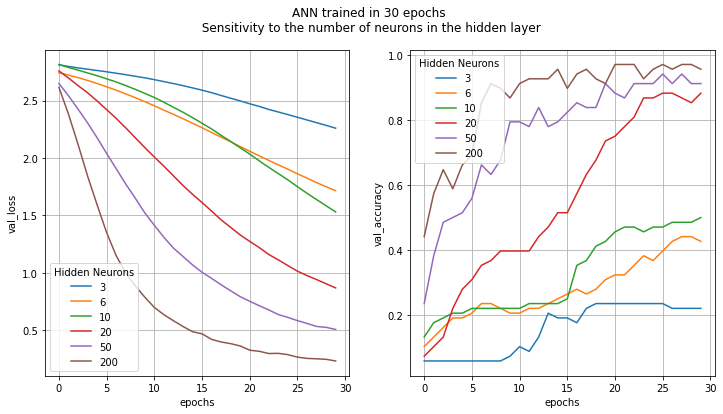

In [211]:
fig, ax = plt.subplots(1,2,figsize=(12, 6))
fig.suptitle(f'ANN trained in {epochs:d} epochs\n Sensitivity to the number of neurons in the hidden layer')

plt.subplot(121)
for h in histories:
  plt.plot(h.history['val_loss']);
plt.legend(hidden_neurons_values, title='Hidden Neurons')
plt.xlabel('epochs')
plt.ylabel('val_loss')
plt.grid()
  
plt.subplot(122)
for h in histories:
  plt.plot(h.history['val_accuracy']);
plt.legend(hidden_neurons_values, title='Hidden Neurons')
plt.xlabel('epochs')
plt.ylabel('val_accuracy')
plt.grid()

pass;

### Note:
The ann learns faster when it's more complex (50 or 200 neurons at the hidden layer)

### Evaluating the netwotk in the test set

### Adding more complexity with a second hidden layer, for the same previous number of neurons in both hidden layers

In [214]:
accs_2_hidden = []
for hn in tqdm(hidden_neurons_values):
  model = keras.Sequential([
    layers.Dense(hn, input_dim=6, activation= 'relu'), #hidden + inputs information
    layers.Dense(hn, activation= 'relu'), #hidden + inputs information
    layers.Dense(num_classes, activation= 'softmax') #output
    # model.summary()
  ])

  model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
  )

  _ = model.fit(
    X_train, 
    y_train,
    epochs=epochs,
    validation_split=0.1,
    verbose=0,
  )
  # predict and  save
  y_pred = model.predict(X_test)
  y_pred = np.argmax(y_pred, 1)
  accs_2_hidden.append(accuracy_score(y_test_non_categorical, y_pred))

100%|██████████| 6/6 [00:17<00:00,  2.95s/it]


#### Comparing accuracies of the two architectures (one and two hidden layers), for the same numbers of neurons in each of them

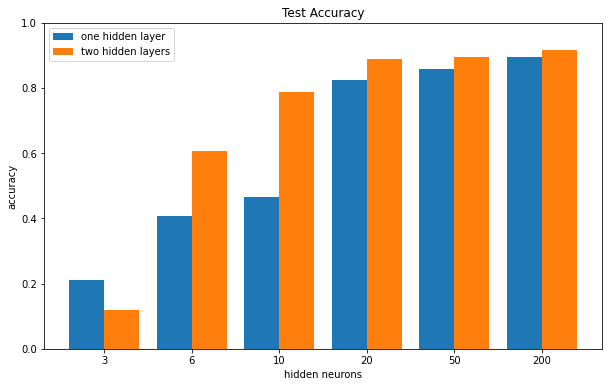

In [215]:
plt.figure(figsize=(10,6))
X_axis = np.arange(len(hidden_neurons_values))
  
plt.bar(X_axis - 0.2, accs, 0.4, label = 'one hidden layer')
plt.bar(X_axis + 0.2, accs_2_hidden, 0.4, label = 'two hidden layers')
plt.xlabel('hidden neurons')
plt.ylabel('accuracy')
plt.title('Test Accuracy')
plt.ylim((0,1))
plt.legend()
  
plt.xticks(X_axis, hidden_neurons_values)
pass;

#### Notes
1.   We see more accuracies in the model with higher complexity (number of hidden neurons)
2.   Adding a second layer improves the quality of the models, this gain of accuracy is more expressive when the number of hidden neurons is low.